4.2 Building on the code in the binder, create 3 pipelines. A simple combination would be Quantile Transformation + Model, Quantile Transformation + Polynomial Transformation + Model.. Save your favorite pipeline, you will need it in the next assignment.

 

Note: Upload a .ipynb file or a pdf of your notebook (preferred).

In [13]:
from sqlalchemy import create_engine
import pymssql
import pandas as pd

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [14]:
server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
database = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()

In [15]:
df = pd.read_sql(
    """
    select date, ticker, bm, mom12m, roeq, siccd, ret
    from data
    order by date, ticker
    """,
    conn
)
df = df.dropna()
df = df.set_index(["date", "ticker"])
features = ["bm", "mom12m", "roeq"]

In [16]:
df["actual"] = df.ret

qt = QuantileTransformer(output_distribution="normal")

grouped = df.groupby("date", group_keys=False)
df[features+["ret"]] = grouped[features+["ret"]].apply(
  lambda d: 
    pd.DataFrame(
      qt.fit_transform(d),
      columns=d.columns,
      index=d.index
    )     
)

In [17]:
inds = pd.read_csv("siccodes12.csv", index_col="industry")
def industry(sic):
    try: return inds[(inds.start<=sic)&(sic<=inds.end)].index[0]
    except: return "Other"
    
codes = pd.Series({code: industry(code) for code in df.siccd.unique()}).reset_index()
codes.columns = ["siccd", "industry"]
df = df.reset_index().merge(codes, on="siccd").set_index(["date", "ticker"])
features.append("industry")

In [18]:
pipe1 = make_pipeline(
    make_column_transformer((OneHotEncoder(), ["industry"]), remainder="passthrough"),
    LinearRegression(fit_intercept=False)
)

pipe2 = make_pipeline(
    make_column_transformer((OneHotEncoder(), ["industry"]), remainder="passthrough"),
    PolynomialFeatures(degree=2),
    LinearRegression(fit_intercept=False)
)

pipe3 = make_pipeline(
    make_column_transformer((OneHotEncoder(), ["industry"]), remainder="passthrough"),
    PolynomialFeatures(degree=3),
    LinearRegression(fit_intercept=False)
)

In [19]:
with open('best_pipeline.pkl', 'wb') as f:
    pickle.dump(pipe2, f)

print("Three pipelines created and Pipeline 2 saved as best_pipeline.pkl")

Three pipelines created and Pipeline 2 saved as best_pipeline.pkl


4.3 Run a backtest loop on one of the pipelines from the last assignment.  Save the predictions to a csv file.  You will use the predictions in your next assignments.

 

Note: Upload a .ipynb file and a .csv file of predictions or a pdf of your notebook (preferred).

In [20]:
dates = ["2005-01", "2010-01", "2015-01", "2020-01", "3000-01"]
predictions = None

for train_date, end_date in zip(dates[:-1], dates[1:]):
  
  fltr1 = df.index.get_level_values("date") < train_date
  fltr2 = df.index.get_level_values("date") < end_date
  train = df[fltr1]
  test = df[~fltr1 & fltr2]

  Xtrain = train[features]
  ytrain = train["ret"]
  Xtest = test[features]
  ytest = test["ret"]

  pipe2.fit(Xtrain, ytrain)
  print('Train set score: ' + str(pipe2.score(Xtrain, ytrain)))

  pred = pipe2.predict(Xtest)
  pred = pd.Series(pred, index=test.index)
  predictions = pd.concat((predictions, pred))
  print('Test set score: ' + str(pipe2.score(Xtest,ytest)))

Train set score: 0.009574115169326602
Test set score: 0.001374573602032192
Train set score: 0.007183717108314003
Test set score: 0.004316111626375685
Train set score: 0.006708201060199315
Test set score: 0.006813238086089912
Train set score: 0.00692597743473411
Test set score: 0.0012358975841959552


In [21]:
df

bm    mom12m      roeq  siccd       ret    actual  \
date    ticker                                                            
2000-01 AA     -0.221091  1.062016  0.513798   3334 -1.147423 -0.160392   
        AABC    1.089328  0.289466  0.914883   6020 -0.172190 -0.029528   
        AAC     1.851066  0.568127  0.908383   6153  0.406022  0.056338   
        AACE   -0.498708  0.327035  0.781803   6090 -0.444534 -0.067568   
        AAG     0.413821 -0.721939  0.127096   3675 -0.701858 -0.100694   
...                  ...       ...       ...    ...       ...       ...   
2022-03 ZTS    -1.365680  0.901439  1.360634   2834 -0.317832 -0.026130   
        ZUMZ    0.208198 -0.115132  0.412236   5600 -1.463068 -0.141155   
        ZVO    -0.047195 -2.020965 -1.303226   8221 -2.140409 -0.261171   
        ZWS    -0.265108  0.993435 -0.431020   3569  0.803551  0.088561   
        ZYNE    0.397684 -1.067936 -1.343087   9999 -1.030619 -0.092920   

                          industry  
date    ticker                      
2000-01 AA           Manufacturing  
        AABC               Finance  
        AAC                Finance  
        AACE               Finance  
        AAG     Business Equipment  
...                            ...  
2022-03 ZTS             Healthcare  
        ZUMZ                 Shops  
        ZVO                  Other  
        ZWS          Manufacturing  
        ZYNE                 Other  

[977804 rows x 7 columns]

In [22]:
df["predict"] = predictions
df.to_csv("predictions.csv")

4.4 Using the predictions from Exercise 4.3, compute and plot the returns of a 150/50 strategy, where each month the long side consists of the 150 top stocks equally weighted, and the short side consists of the 100 bottom stocks equally weighted.  

 

Note: Upload a .ipynb file or a pdf of your notebook (preferred).

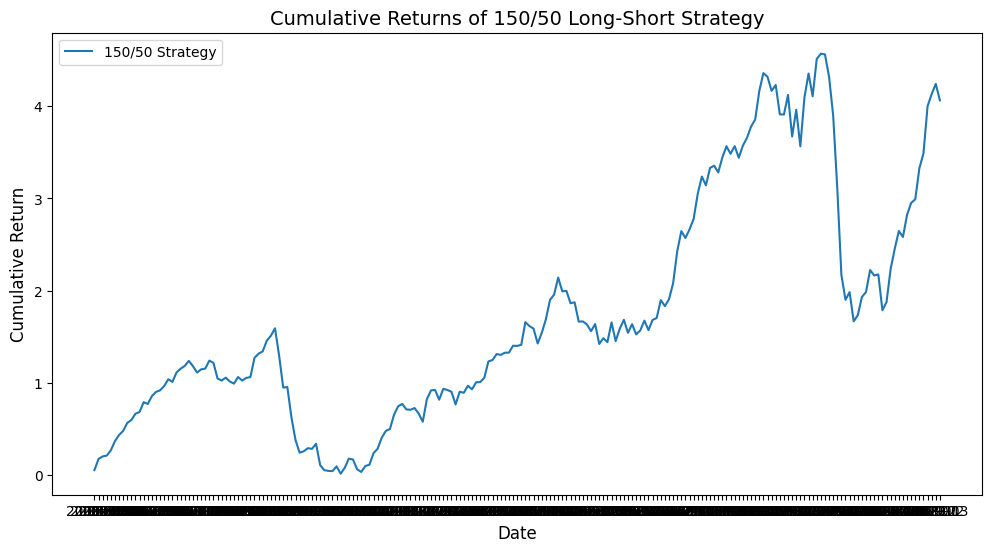

In [34]:
import matplotlib.pyplot as plt

numlong = 150
numshort = 100

df["rank_from_top"] = df.groupby("date").predict.rank(
  method="first", 
  ascending=False
)
df["long"] = df.rank_from_top <= numlong

df["rank_from_bottom"] = df.groupby("date").predict.rank(
  method="first"
)
df["short"] = df.rank_from_bottom <= numshort

df = df[df.index.get_level_values("date") >= dates[0]]

long_ret = df[df.long].groupby("date").actual.mean()
short_ret = df[df.short].groupby("date").actual.mean()


ret = 1.5 * long_ret - 0.5 * short_ret

#Plotting
cumulative_ret = (1 + ret).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(cumulative_ret.index, cumulative_ret, label='150/50 Strategy')

plt.title('Cumulative Returns of 150/50 Long-Short Strategy', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend()
plt.show()

In [31]:
ret

date
2005-01    0.053441
2005-02    0.114458
2005-03    0.023522
2005-04    0.007499
2005-05    0.047642
             ...   
2021-11    0.037313
2021-12    0.114036
2022-01    0.026445
2022-02    0.021492
2022-03   -0.034094
Name: actual, Length: 207, dtype: float64